In [1]:
%cd /home/mdiaz/hackaton-csbig/ranger/piloto/clean_adata/

/datos/home/mdiaz/hackaton-csbig/ranger/piloto/clean_adata


In [2]:
import numpy as np
import scanpy as sc
import seaborn as sns
import pandas as pd 
import scvi
from scipy.stats import median_abs_deviation
import matplotlib.pyplot as plt
import os
from scipy.stats import median_abs_deviation as mad
sc.settings.verbosity = 0
sc.settings.set_figure_params(
    dpi=120,
    facecolor="white",
    frameon=False,
)

In [3]:
os.listdir ("../clean_adata/")

['cb_leukimia_gene_raw_bc_matrices.h5',
 'cb_leukimia_gene_raw_bc_matrices.h_posterior.h5',
 'cb_postAML_leukimia_gene_raw_bc_matrices.pdf',
 'cb_postAML_leukimia_gene_raw_bc_matrices.log',
 'cb_leukimia_gene_raw_bc_matrices.log',
 'cb_postAML_leukimia_gene_raw_bc_matrices.h5',
 'cb_leukimia_gene_raw_bc_matrices.pdf',
 'cb_postAML_leukimia_gene_raw_bc_matrices_cell_barcodes.csv',
 'cb_postAML_leukimia_gene_raw_bc_matrices.h_posterior.h5',
 'cb_postAML_leukimia_gene_raw_bc_matrices_metrics.csv',
 'cb_leukimia_gene_raw_bc_matrices_metrics.csv',
 'cb_leukimia_gene_raw_bc_matrices_cell_barcodes.csv',
 'cb_postAML_leukimia_gene_raw_bc_matrices_filtered.h5',
 'cb_leukimia_gene_raw_bc_matrices_filtered.h5']

# QC preprocess for leukimia dataset 

In [15]:
adatas = [x for x in os.listdir('../clean_adata/') if x.endswith('filtered.h5')]
adatas

['cb_postAML_leukimia_gene_raw_bc_matrices_filtered.h5',
 'cb_leukimia_gene_raw_bc_matrices_filtered.h5']

In [16]:
adatas

['cb_postAML_leukimia_gene_raw_bc_matrices_filtered.h5',
 'cb_leukimia_gene_raw_bc_matrices_filtered.h5']

In [17]:
def load_it(adata):
    samp = adata.split('_')[0]
    dx = adata.split('_')[1]
    adata = sc.read_10x_h5('../clean_adata/' + adata)
    adata.obs['Patient'] = samp
    adata.obs['DX'] = dx
    adata.obs['Sample'] = adata.obs['Patient'] + '_' + adata.obs['DX']
    adata.obs.index = adata.obs.index + '-' + samp + '_' + dx
    return adata

In [19]:
adatas = [load_it(ad) for ad in adatas]

for adata in adatas:
    adata.var_names_make_unique()
    print(f"Unique var names for {adata.obs['Sample'][0]}: {adata.var_names.is_unique}")

adatas

Unique var names for cb_postAML: True
Unique var names for cb_leukimia: True


/tmp/ipykernel_959187/4000275214.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"Unique var names for {adata.obs['Sample'][0]}: {adata.var_names.is_unique}")


[AnnData object with n_obs × n_vars = 1699 × 32738
     obs: 'Patient', 'DX', 'Sample'
     var: 'gene_ids', 'feature_types', 'genome',
 AnnData object with n_obs × n_vars = 8573 × 32738
     obs: 'Patient', 'DX', 'Sample'
     var: 'gene_ids', 'feature_types', 'genome']

In [25]:
def qc(adata):
    
    sc.pp.filter_cells(adata, min_genes = 200) 
    
    adata.var["mt"] = adata.var_names.str.startswith("MT-")
    sc.pp.calculate_qc_metrics(adata, qc_vars="mt", inplace=True, percent_top=[20], log1p=True)

    remove = ['total_counts_mt', 'log1p_total_counts_mt']
    
    adata.obs = adata.obs[[x for x in adata.obs.columns if x not in remove]]
    
    return adata

In [26]:
adatas = [qc(ad) for ad in adatas]

In [27]:
df = pd.concat(x.obs for x in adatas)

In [28]:
df = df.sort_values('Sample')

In [29]:
df

,Patient,DX,Sample,n_genes,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_20_genes,pct_counts_mt
TGCACGCTCCAAGT-1-cb_leukimia,cb,leukimia,cb_leukimia,273,273,5.613128,3277.0,8.094989,89.533110,0.061031
TCGAGCCTAAGAGT-4-cb_leukimia,cb,leukimia,cb_leukimia,250,250,5.525453,932.0,6.838405,41.416309,2.360515
CATAGTCTGTACCA-3-cb_leukimia,cb,leukimia,cb_leukimia,513,513,6.242223,1178.0,7.072422,30.050934,2.461800
ACTGTTACGGGATG-4-cb_leukimia,cb,leukimia,cb_leukimia,740,740,6.608001,1437.0,7.271009,16.562283,1.113431
GTAGCCCTGCAGAG-4-cb_leukimia,cb,leukimia,cb_leukimia,504,504,6.224558,1317.0,7.183871,32.574032,1.594533
...,...,...,...,...,...,...,...,...,...,...
ATGCGATGTGTGCA-2-cb_postAML,cb,postAML,cb_postAML,468,468,6.150603,2140.0,7.669028,33.317757,0.140187
GATCCCTGTGGTAC-2-cb_postAML,cb,postAML,cb_postAML,322,322,5.777652,2063.0,7.632401,82.598158,0.096946
TAATCGCTTGCACA-2-cb_postAML,cb,postAML,cb_postAML,201,201,5.308268,2052.0,7.627057,89.961014,0.000000
TTTCGAACAACGGG-1-cb_postAML,cb,postAML,cb_postAML,317,317,5.762051,2020.0,7.611348,81.089109,0.000000


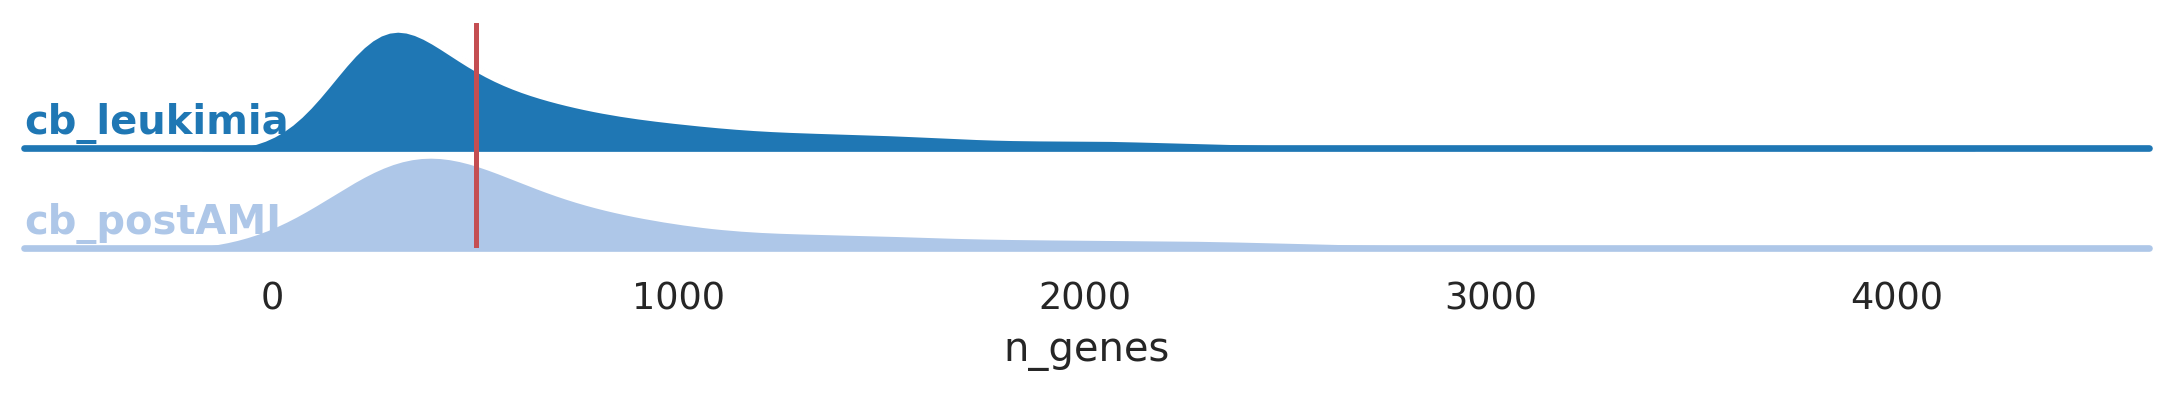

In [30]:
#value = "pct_counts_mt"
value = "n_genes"
#value = 'pct_counts_in_top_20_genes'
#value = "log1p_total_counts"

sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

g = sns.FacetGrid(df, row="Sample", hue="Sample", aspect=10, height=1, palette="tab20")

g.map(sns.kdeplot, value, clip_on=False, fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, value, clip_on=False, color="w", lw=2)

g.map(plt.axhline, y=0, lw=2, clip_on=False)

def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)

g.map(label, value)

g.figure.subplots_adjust(hspace=-0.2)

g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)

for ax in g.axes.flat:
    ax.axvline(x=df[value].median(), color='r', linestyle='-')


plt.show()

In [31]:
def mad_outlier(adata, metric, nmads, upper_only = False):
    M = adata.obs[metric]
    
    if not upper_only:
        return (M < np.median(M) - nmads * mad(M)) | (M > np.median(M) + nmads * mad(M))
    
    return (M > np.median(M) + nmads * mad(M))


In [32]:
def pp(adata):
    adata = adata[adata.obs.pct_counts_mt < 25] #you can lower this based on the overal distribution of your dataset
    
    bool_vector = mad_outlier(adata, 'log1p_total_counts', 5) +\
            mad_outlier(adata, 'log1p_n_genes_by_counts', 5) +\
            mad_outlier(adata, 'pct_counts_in_top_20_genes', 5) +\
            mad_outlier(adata, 'pct_counts_mt', 3, upper_only = True)
    adata = adata[~bool_vector]

    adata.uns['cells_removed'] = sum(bool_vector)

    return adata

In [33]:
adatas = [pp(ad) for ad in adatas]

/tmp/ipykernel_959187/2384527837.py:10: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns['cells_removed'] = sum(bool_vector)


In [34]:
for adata in adatas:
    print(len(adata), adata.uns['cells_removed'])

546 193
2644 389


In [35]:
adatas

[AnnData object with n_obs × n_vars = 546 × 32738
     obs: 'Patient', 'DX', 'Sample', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'pct_counts_mt'
     var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
     uns: 'cells_removed',
 AnnData object with n_obs × n_vars = 2644 × 32738
     obs: 'Patient', 'DX', 'Sample', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'pct_counts_mt'
     var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
     uns: 'cells_removed']

In [37]:
df2 = pd.concat([x.obs for x in adatas])
df2 = df2.sort_values('Sample')

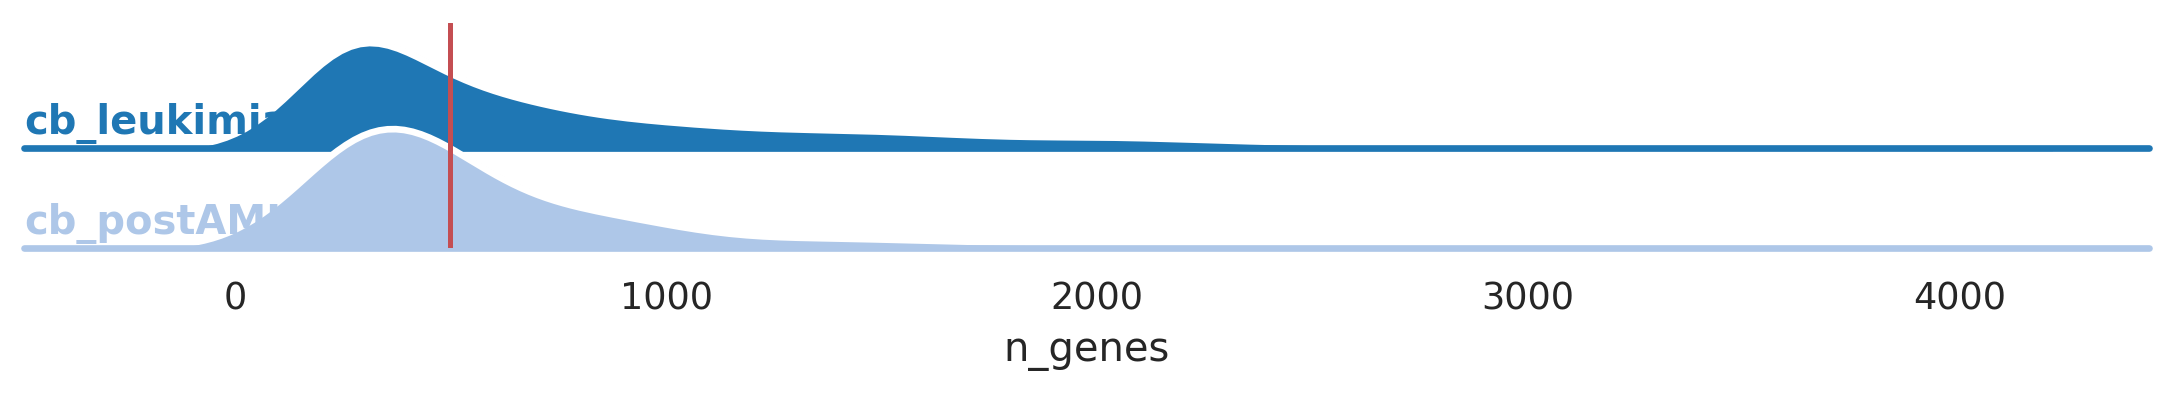

In [38]:
#value = "pct_counts_mt"
value = "n_genes"
#value = 'pct_counts_in_top_20_genes'
#value = "log1p_total_counts"

sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

g = sns.FacetGrid(df2, row="Sample", hue="Sample", aspect=10, height=1, palette="tab20")

g.map(sns.kdeplot, value, clip_on=False, fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, value, clip_on=False, color="w", lw=2)

g.map(plt.axhline, y=0, lw=2, clip_on=False)

def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)

g.map(label, value)

g.figure.subplots_adjust(hspace=-0.2)

g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)

for ax in g.axes.flat:
    ax.axvline(x=df2[value].median(), color='r', linestyle='-')


plt.show()

# Doublet removal

In [39]:
import scanpy as sc
import scvi

# Iterar sobre las listas de AnnData en adatas
for i, adata in enumerate(adatas):
    print(f"Procesando el conjunto de datos {i+1}")
    
    # Paso 1: Preprocesamiento
    # Filtrar genes que no se expresan en al menos 10 células
    sc.pp.filter_genes(adata, min_cells=10)
    
    # Seleccionar los 2000 genes más variables
    sc.pp.highly_variable_genes(adata, n_top_genes=2000, subset=False, flavor='seurat_v3')
    sc.pp.pca(adata, n_comps=50, mask_var="highly_variable")
    sc.pp.neighbors(adata, use_rep='X_pca')
    sc.tl.umap(adata)
    # Verificación después del preprocesamiento
    print(f"Datos después del filtrado de genes y selección de genes variables: {adata.shape}")
    adata.X = adata.X.tocsr()
    # Paso 2: Configurar y entrenar el modelo scVI
    scvi.model.SCVI.setup_anndata(adata)
    vae = scvi.model.SCVI(adata)
    vae.train()

    # Paso 3: Aplicar SOLO para detectar dobletes
    solo = scvi.external.SOLO.from_scvi_model(vae)
    solo.train()

    # Obtener las predicciones
    df = solo.predict()
    
    # Generar etiquetas binarias (predicción directa de doublet o singlet)
    df['prediction'] = solo.predict(soft=False)
    
    # Calcular la diferencia entre la probabilidad de 'doublet' y 'singlet'
    df['dif'] = df.doublet - df.singlet

    # Paso 4: Filtrar células dobletes con un umbral de dif > 0.9
    doublets = df[(df.prediction == 'doublet') & (df.dif > 0.9)]

    # Ver cuántas células están etiquetadas como dobletes
    print(f"Total de células etiquetadas como doblete con dif > 0.9: {doublets.shape[0]}")

    # Paso 5: Crear una nueva columna en adata.obs que indique si la célula es un doblete
    adata.obs['doublet'] = adata.obs.index.isin(doublets.index)

    # Paso 6: Filtrar las células que no son dobletes (i.e., mantener solo singletes)
    adata_filtrado = adata[~adata.obs['doublet']]

    # Actualizar la lista adatas con el objeto filtrado
    adatas[i] = adata_filtrado

    # Verificación después del filtrado de dobletes
    print(f"Datos restantes después de filtrar dobletes: {adata_filtrado.shape}")


Procesando el conjunto de datos 1


2025-03-08 00:20:28.462003: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-08 00:20:28.486550: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-08 00:20:28.493779: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-08 00:20:36.550192: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Datos después del filtrado de genes y selección de genes variables: (546, 6052)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/mdiaz/miniconda3/envs/sc_kernel/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=79` in the `DataLoader` to improve performance.
/home/mdiaz/miniconda3/envs/sc_kernel/lib/python3.9/site-packages/lightning/pytorch/loops/fit_loop.py:293: The number of training batches (4) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 400/400: 100%|██████████████████████████████████████████████████████████████████████| 400/400 [00:32<00:00, 14.82it/s, v_num=1, train_loss_step=1.75e+3, train_loss_epoch=1.7e+3]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████████████████████████████████████████████████████████████████| 400/400 [00:32<00:00, 12.19it/s, v_num=1, train_loss_step=1.75e+3, train_loss_epoch=1.7e+3]
INFO     Creating doublets, preparing SOLO model.                                                                  


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/mdiaz/miniconda3/envs/sc_kernel/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=79` in the `DataLoader` to improve performance.
/home/mdiaz/miniconda3/envs/sc_kernel/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=79` in the `DataLoader` to improve performance.


Epoch 31/400:   8%|█████▉                                                                       | 31/400 [00:02<00:28, 13.16it/s, v_num=1, train_loss_step=0.489, train_loss_epoch=0.4]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.666. Signaling Trainer to stop.
Total de células etiquetadas como doblete con dif > 0.9: 92
Datos restantes después de filtrar dobletes: (454, 6052)
Procesando el conjunto de datos 2


/home/mdiaz/miniconda3/envs/sc_kernel/lib/python3.9/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/home/mdiaz/miniconda3/envs/sc_kernel/lib/python3.9/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0

Datos después del filtrado de genes y selección de genes variables: (2644, 10640)
Epoch 400/400: 100%|██████████████████████████████████████████████████████████████████████| 400/400 [01:50<00:00,  3.65it/s, v_num=1, train_loss_step=1.92e+3, train_loss_epoch=2.1e+3]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████████████████████████████████████████████████████████████████| 400/400 [01:50<00:00,  3.62it/s, v_num=1, train_loss_step=1.92e+3, train_loss_epoch=2.1e+3]
INFO     Creating doublets, preparing SOLO model.                                                                  


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/mdiaz/miniconda3/envs/sc_kernel/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=79` in the `DataLoader` to improve performance.
/home/mdiaz/miniconda3/envs/sc_kernel/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=79` in the `DataLoader` to improve performance.


Epoch 351/400:  88%|████████████████████████████████████████████████████████████████         | 351/400 [01:18<00:10,  4.47it/s, v_num=1, train_loss_step=0.266, train_loss_epoch=0.308]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.343. Signaling Trainer to stop.
Total de células etiquetadas como doblete con dif > 0.9: 43
Datos restantes después de filtrar dobletes: (2601, 10640)


/home/mdiaz/miniconda3/envs/sc_kernel/lib/python3.9/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/home/mdiaz/miniconda3/envs/sc_kernel/lib/python3.9/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)


In [40]:
adata = sc.concat(adatas, join='outer')

In [41]:
adata

AnnData object with n_obs × n_vars = 3055 × 10728
    obs: 'Patient', 'DX', 'Sample', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'pct_counts_mt', '_scvi_batch', '_scvi_labels', 'doublet'
    obsm: 'X_pca', 'X_umap'

In [42]:
adata.write('/home/mdiaz/sc_liver_data/checkpoints/doublets_removed.h5ad')